### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 7
### Due: Saturday, Mar 29th at 11.59pm CT
---

This is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. his is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. 

Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

In [197]:
# install the relevant interactive plot packages
# only do this once

import numpy as np
from scipy import stats
import scipy.special as sp
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from matplotlib import pyplot as plt
import corner.corner as corner
import emcee
import acor
import dynesty
import ultranest
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression, Ridge
from ultranest.plot import cornerplot
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity, KNeighborsRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor

In [4]:
#!pip install ipywidgets ipympl

Question 1: I will be loading in the data and plotting the features(x) vs y.

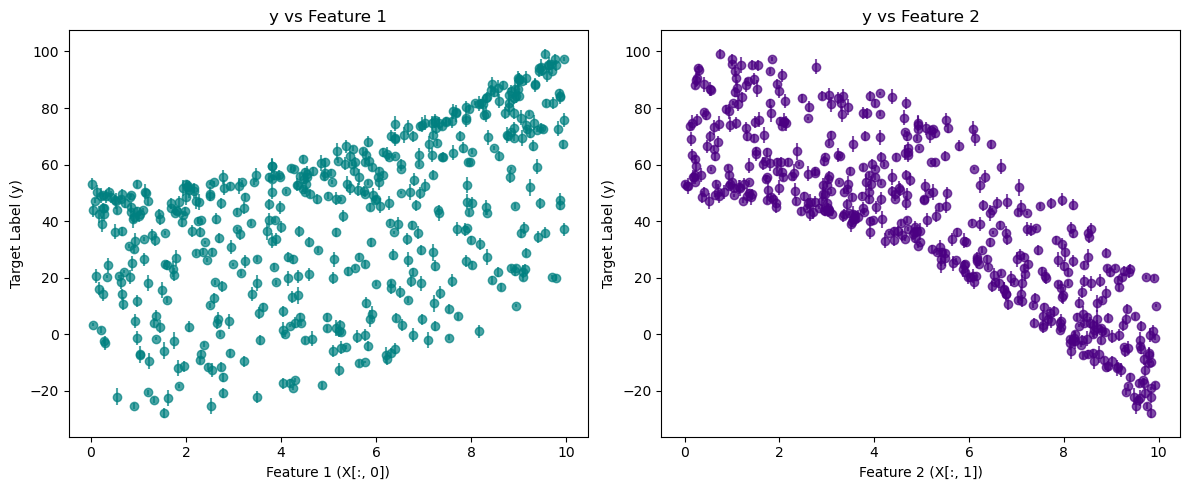

In [98]:
### Always do this line at the start
### of a static plotting cell
%matplotlib inline
data = np.load("hw_data/hw7_data_1.npy")
X = data[:, :2]    # First two columns: features
y = data[:, 2]    
yerr = data[:, 3]  
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Panel 1: y vs. Feature 1
ax[0].errorbar(X[:, 0], y, yerr=yerr, fmt='o', alpha=0.7, color='teal')
ax[0].set_xlabel("Feature 1 (X[:, 0])")
ax[0].set_ylabel("Target Label (y)")
ax[0].set_title("y vs Feature 1")

# Panel 2: y vs. Feature 2
ax[1].errorbar(X[:, 1], y, yerr=yerr, fmt='o', alpha=0.7, color='indigo')
ax[1].set_xlabel("Feature 2 (X[:, 1])")
ax[1].set_ylabel("Target Label (y)")
ax[1].set_title("y vs Feature 2")

plt.tight_layout()
plt.show()
plt.close('all')

2) Fit the data to uncertainties.

Intercept: 4.900419793970054
Slopes: [-8.14841188]


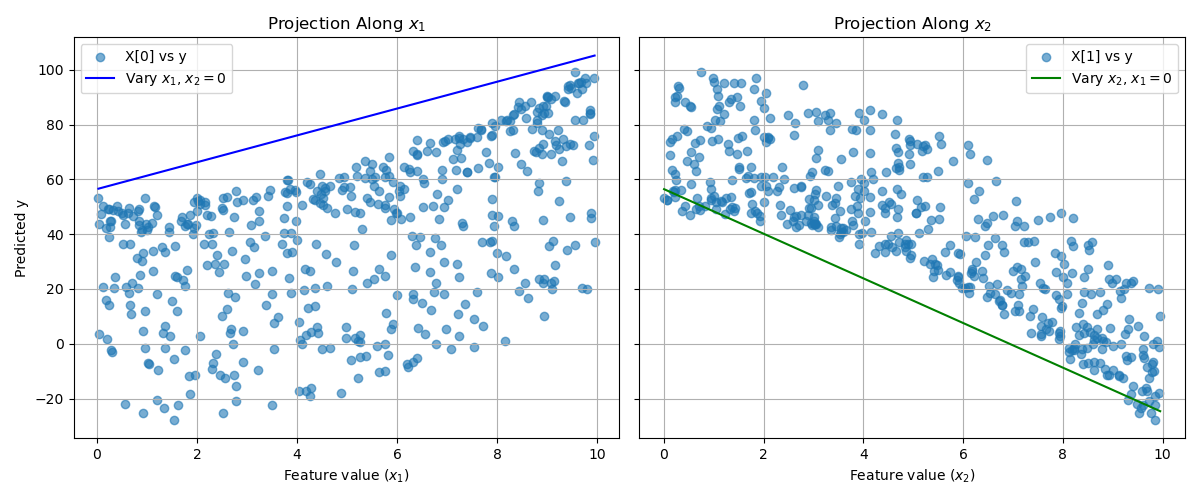

In [155]:
X = np.column_stack((X[:, 0],X[:, 1]))
model = LinearRegression()
zeros=np.zeros(50)#
x1_vals = np.linspace(min(X[:, 0]), max(X[:, 0]), 50)
x2_vals = np.linspace(min(X[:, 1]), max(X[:, 1]), 50)


results = model.fit(X, y, yerr)

#Print the best-fit intercept and slopes for the features.
print("Intercept:", model.coef_[0])
print("Slopes:", model.coef_[1:]) #hope this is right


# Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature
model = LinearRegression()
zeros=np.zeros(50)#
X = np.column_stack((X[:, 0],X[:, 1]))
x1_vals = np.linspace(min(X[:, 0]), max(X[:, 0]), 50)
x2_vals = np.linspace(min(X[:, 1]), max(X[:, 1]), 50)

results = model.fit(X, y, yerr)
xgrid1 = np.column_stack((x1_vals, zeros))  # Vary x1, fix x2 at 0
xgrid2 = np.column_stack((zeros, x2_vals))  # Vary x2, fix x1 at 0
ypred1=model.predict(xgrid1)
ypred2=model.predict(xgrid2)
#plot the best-fit model on a duplicate of the $2$-panel plot from (1)
# Plot 1: x1 vs y
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1: x1 vs y
axes[0].scatter(X[:, 0], y, alpha=0.6, label='X[0] vs y')
axes[0].plot(x1_vals, ypred1, label='Vary $x_1$, $x_2=0$', color='blue')
axes[0].set_xlabel('Feature value ($x_1$)')
axes[0].set_ylabel('Predicted y')
axes[0].set_title('Projection Along $x_1$')
axes[0].legend()
axes[0].grid(True)

# Plot 2: x2 vs y
axes[1].scatter(X[:, 1], y, alpha=0.6, label='X[1] vs y')
axes[1].plot(x2_vals, ypred2, label='Vary $x_2$, $x_1=0$', color='green')
axes[1].set_xlabel('Feature value ($x_2$)')
axes[1].set_title('Projection Along $x_2$')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Question:  does this look like a good description of the data?
Answer: Ahhhh. I think it looks like a description of the data. I think for feature value 2 it may match the data more. However i think that the predicted yintercepts are off, which is why the fit is a little off. 

3.)Make a new two-dimensional prediction meshgrid Xgrid over the 2-D feature space, use your best-fit model to predict the labels, and make a 2-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

[[0.02954295 0.23192135 0.43429974 ... 9.54132751 9.74370591 9.9460843 ]
 [0.02954295 0.23192135 0.43429974 ... 9.54132751 9.74370591 9.9460843 ]
 [0.02954295 0.23192135 0.43429974 ... 9.54132751 9.74370591 9.9460843 ]
 ...
 [0.02954295 0.23192135 0.43429974 ... 9.54132751 9.74370591 9.9460843 ]
 [0.02954295 0.23192135 0.43429974 ... 9.54132751 9.74370591 9.9460843 ]
 [0.02954295 0.23192135 0.43429974 ... 9.54132751 9.74370591 9.9460843 ]]


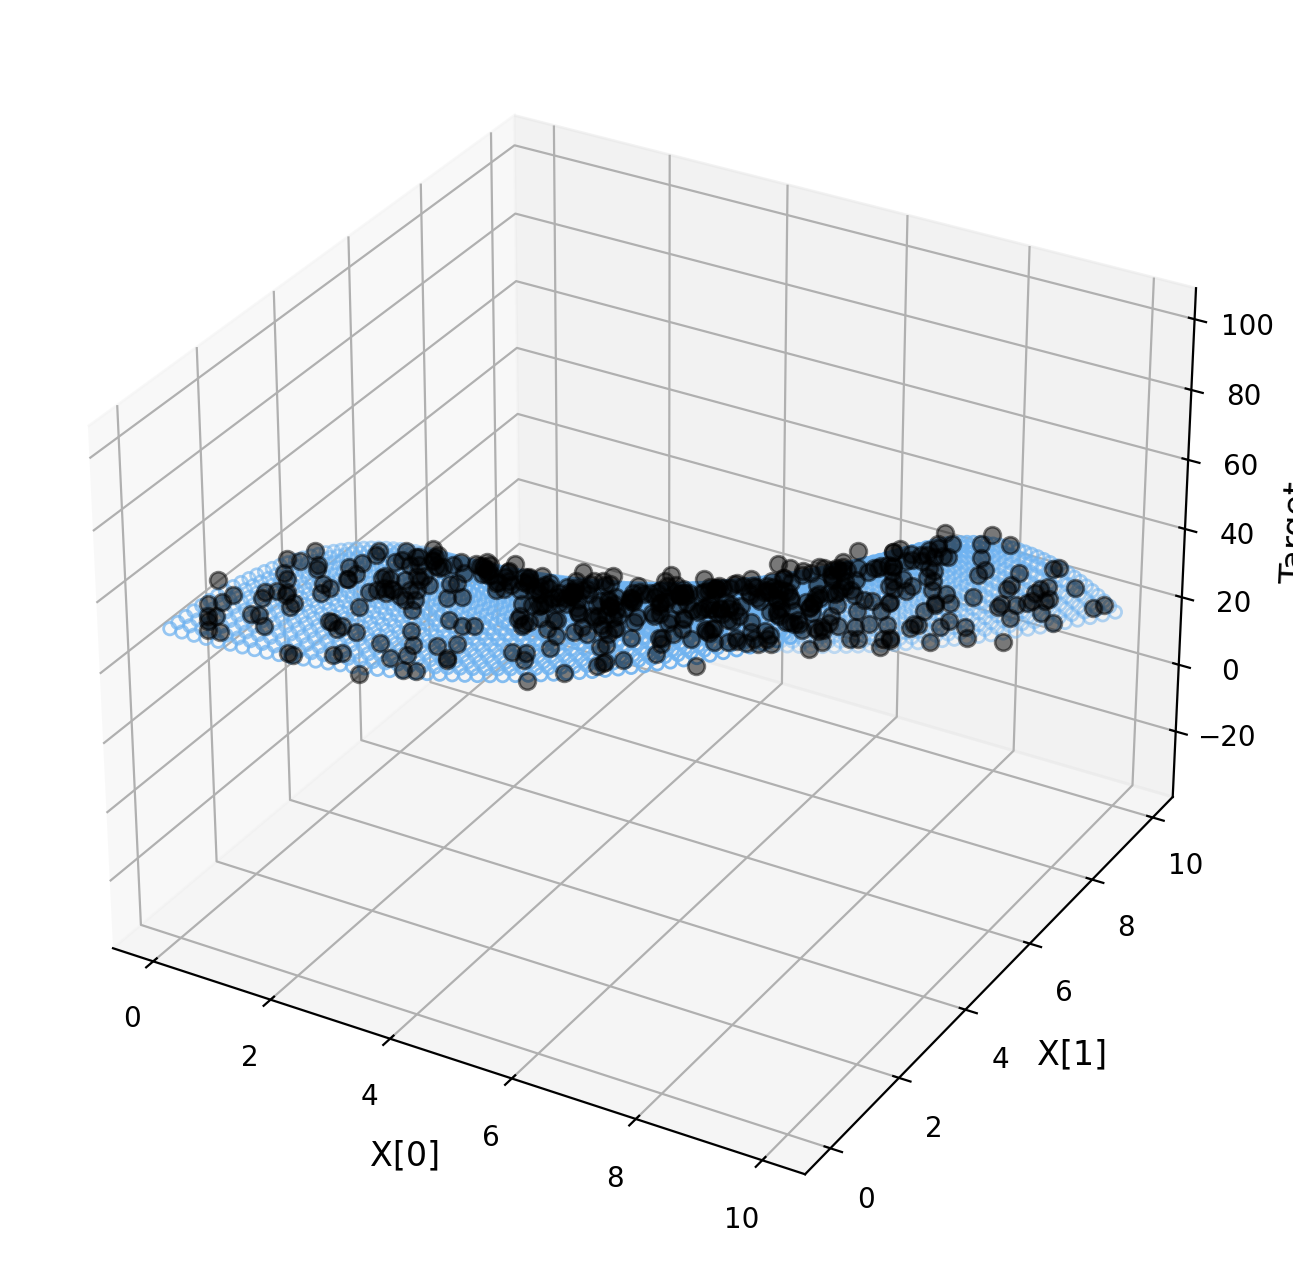

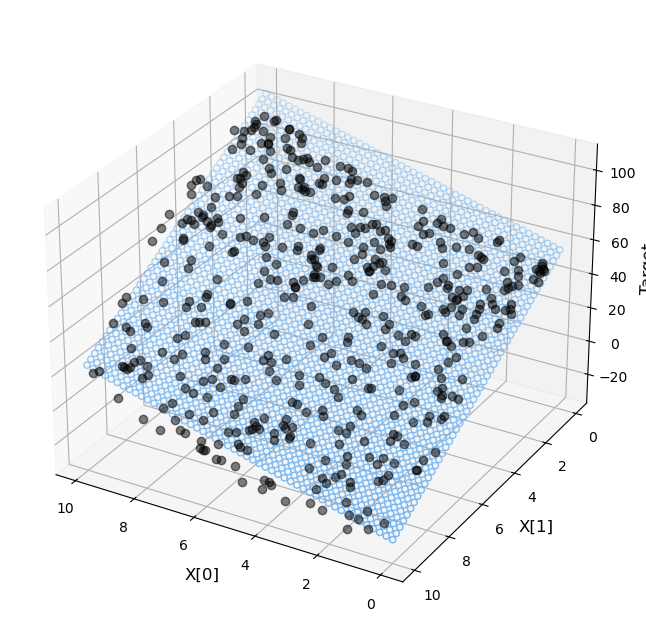

In [256]:
%matplotlib inline
#Make a new two-dimensional prediction meshgrid Xgrid
X1_grid, X2_grid = np.meshgrid(x1_vals, x2_vals) # the 2d space comes from the x1,x2
print(X1_grid)
Xgrid = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
ygrid = model.predict(Xgrid)#use your best-fit model to predict the labels
Ygrid = ygrid.reshape(X1_grid.shape) 
# a 2-D interactive plot showing the data and your best-fit over the entire space.
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:, 0], X[:, 1], y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(X1_grid, X2_grid, Ygrid, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

# I wish I had time to make this asthetically pleasing 

4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

4.)Fit the data with the best options, and visualize interactively. Try RidgeCV also; what cross-validated alpha_ does it return, and does this agree with GridSeachCV? 

Q: What are the best_params_ and the best_score_ from this 

The best parameters is when alpha =1 with the solver as Singular Value Decomposition - ALC





Best parameters: {'alpha': 1.0, 'solver': 'svd'}
Best cross-validation score: 0.9252218454230047


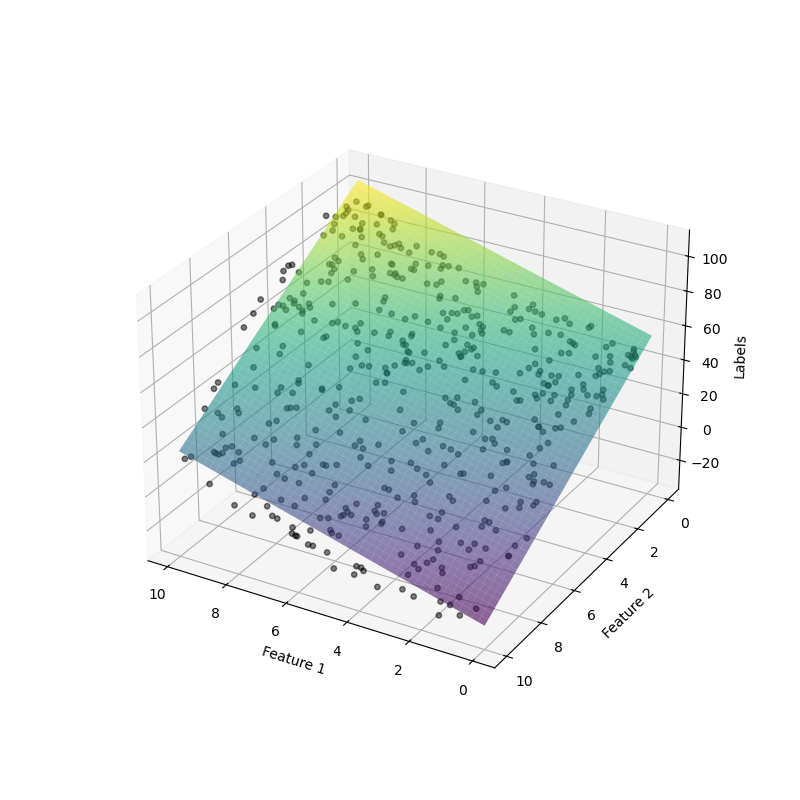

In [188]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_params, cv=5)
grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
bestparams=grid_search.best_params_

ridge = Ridge(alpha = bestparams['alpha'], solver = bestparams['solver'])#Fit the data with the best options
ridge.fit(X_train, y_train)
y_ridge = ridge.predict(Xgrid)
y_ridge = ygrid.reshape(X1_grid.shape) 



#visualize interactively
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, color='k', alpha=0.5, s=15)
ax.plot_surface(X1_grid, X2_grid, y_ridge, cmap='viridis', alpha=0.6)

# Labels and view
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Labels')
ax.view_init(elev=28, azim=120)

plt.show()

RidgeCV best alpha: 1.0
This looks like it matches! -ALC


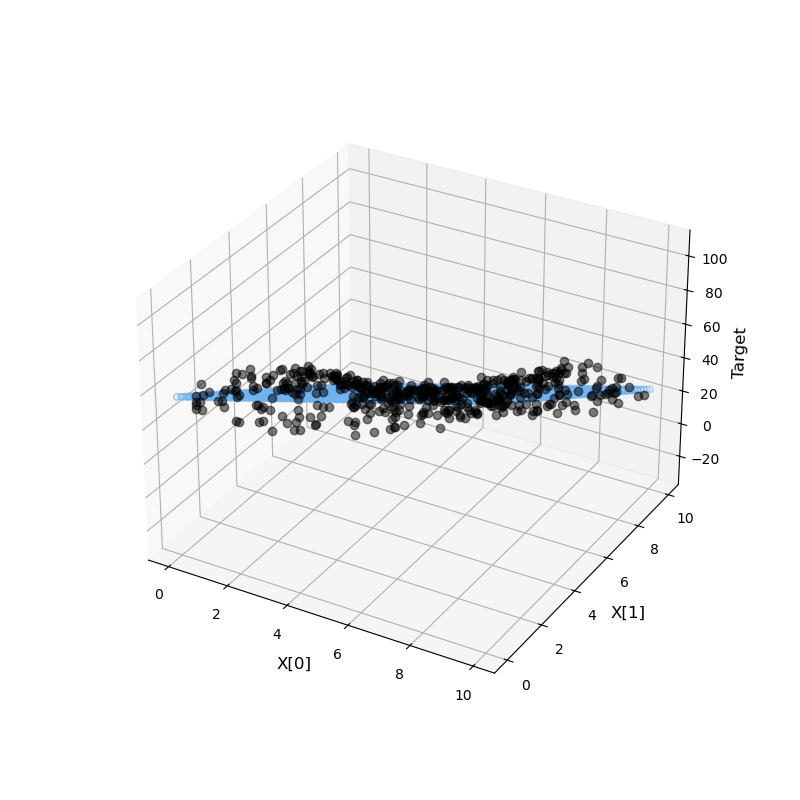

In [192]:
# Perform RidgeCV with the best alpha value
bestalpha = grid_search.best_params_['alpha']  # Assuming grid_search is already defined
ridgecv = RidgeCV(alphas=[bestalpha])
ridgecv.fit(X, y)
print("RidgeCV best alpha:", ridgecv.alpha_)
print("This looks like it matches! -ALC")
# Make predictions for the Xgrid
y_ridgecv = ridgecv.predict(Xgrid)

# Create a figure for 3D plotting
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

# Scatter the original data points
ax.plot(X[:, 0], X[:, 1], y, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)

Xgrid_reshaped = Xgrid.reshape(-1, 2) 
ax.scatter(Xgrid_reshaped[:, 0], Xgrid_reshaped[:, 1], y_ridgecv, 
           facecolor=(0, 0, 0, 0), s=20, edgecolor='#70b3f0')

ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

# Show the plot
plt.show()


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for

It looks fine, I would switch the reference frame if I could!

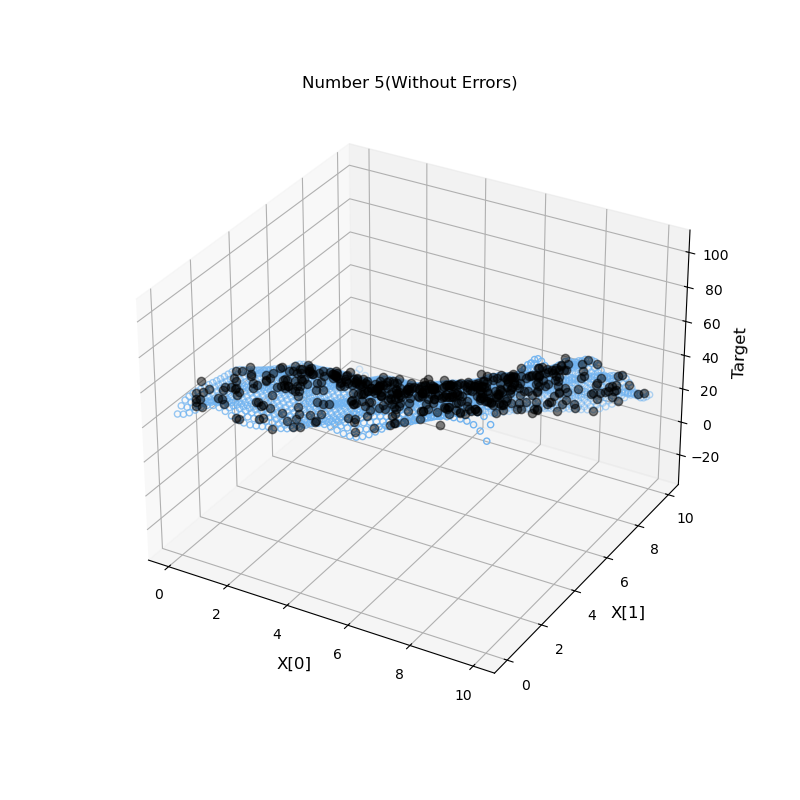

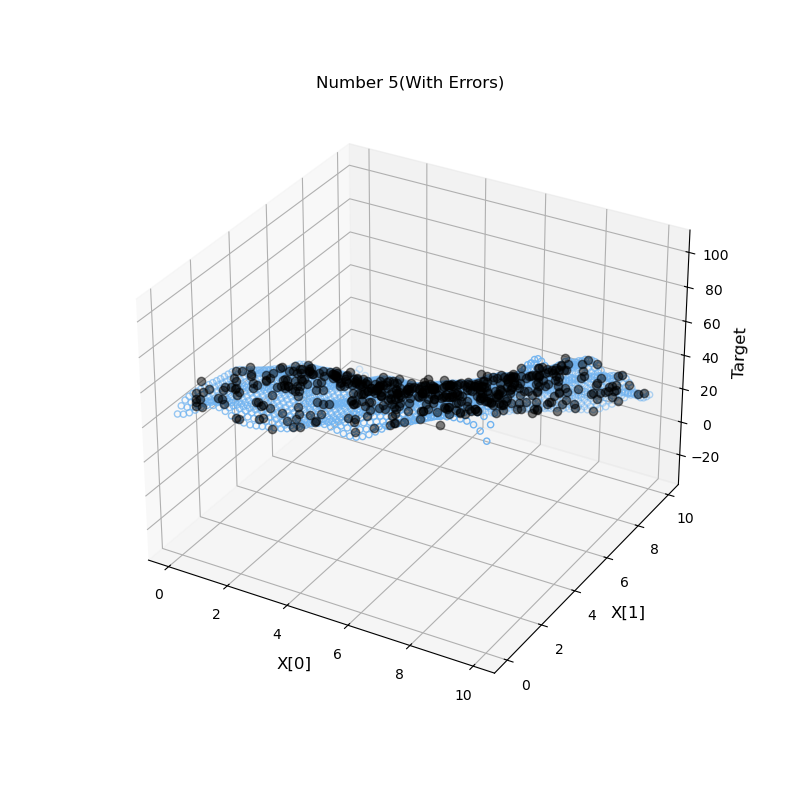

In [238]:
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 



#model the data using Gaussian process regression and the default kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

gpralpha = GaussianProcessRegressor(alpha=(yerr/y)**2)
gpralpha.fit(X, y)
y_gpralpha = gpralpha.predict(Xgrid)


# Plot with uncertainties
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:, 0], X[:, 1], y, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
ax.scatter(Xgrid[:, 0], Xgrid[:, 1], y_gpralpha, facecolor=(0, 0, 0, 0), s=20, edgecolor='#70b3f0')
#ax.plot_trisurf(Xgrid[:, 0], Xgrid[:, 1], y_pred + sigma, color='red', alpha=0.2)
#ax.plot_trisurf(Xgrid[:, 0], Xgrid[:, 1], y_pred - sigma, color='blue', alpha=0.2)
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)
plt.title("Number 5(With Errors)")


#without errors

gpralphaWO = GaussianProcessRegressor()
gpralphaWO.fit(X, y)
y_gpralphaWO = gpralpha.predict(Xgrid)
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:, 0], X[:, 1], y, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
ax.scatter(Xgrid[:, 0], Xgrid[:, 1], y_gpralphaWO, facecolor=(0, 0, 0, 0), s=20, edgecolor='#70b3f0')
#ax.plot_trisurf(Xgrid[:, 0], Xgrid[:, 1], y_pred + sigma, color='red', alpha=0.2)
#ax.plot_trisurf(Xgrid[:, 0], Xgrid[:, 1], y_pred - sigma, color='blue', alpha=0.2)
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

plt.title("Number 5(Without Errors)")#have to start putting titles due to widget errors
plt.show()

6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression
coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear
model and GPR models?

This looks cooler. If i could add a color bar I think you would notice the curves a bit better. This shows a better fit. -ALC

Polynomial regression coefficients: [ 0.00000000e+00  3.26437755e-01  7.04566290e-02  3.76478281e-01
 -2.37398556e-02 -8.70986046e-01  1.19122182e-02  2.54637597e-02
 -1.32002013e-02  2.02705370e-02 -4.53796076e-04 -5.21142180e-04
 -2.06194460e-03  1.68744189e-03 -1.52054198e-03]


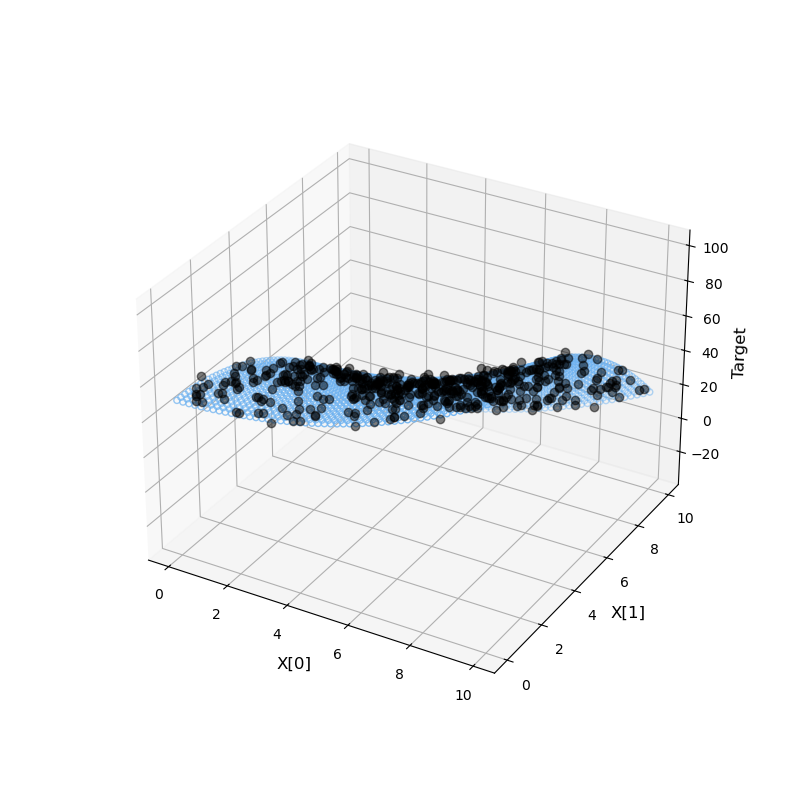

In [254]:
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 

poly = PolynomialFeatures(degree=4)#Fit a $4$th degree polynomial to the data.
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Get the coefficients of the polynomial regression
print("Polynomial regression coefficients:", poly_model.coef_)# Print the best-fit regression

# Predict on the meshgrid (Xgrid) using the polynomial model
Xgrid_poly = poly.transform(Xgrid)  # Transform the meshgrid to match the feature space
y_poly_pred = poly_model.predict(Xgrid_poly)

# Plot the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points
ax.plot(X[:, 0], X[:, 1], y, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)

# Plot the predictions from the polynomial model
ax.scatter(Xgrid[:, 0], Xgrid[:, 1], y_poly_pred, facecolor=(0, 0, 0, 0), s=20, edgecolor='#70b3f0')

# Set the labels for the plot
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

plt.show()

7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
A
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. 
Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). 
Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
B
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from 
$1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
C
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the
labels of the held-out test set, and finally compute the testing rms error.

In [283]:
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
'''
7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
A
- 
Then (leaving a somewhat smaller set to use for training). 
Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
B
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from 
$1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
C
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the
labels of the held-out test set, and finally compute the testing rms error.
'''

<>:4: SyntaxWarning: invalid escape sequence '\%'
<>:4: SyntaxWarning: invalid escape sequence '\%'
/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_4638/3053104726.py:4: SyntaxWarning: invalid escape sequence '\%'
  '''


"\n7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. \nA\n- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\\%$. \nThen split out $20\\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). \nNote that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.\nB\n- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from \n$1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. \nC\n- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the\nlabels of the held-out test set, and finally compute the testing rms error.\n"

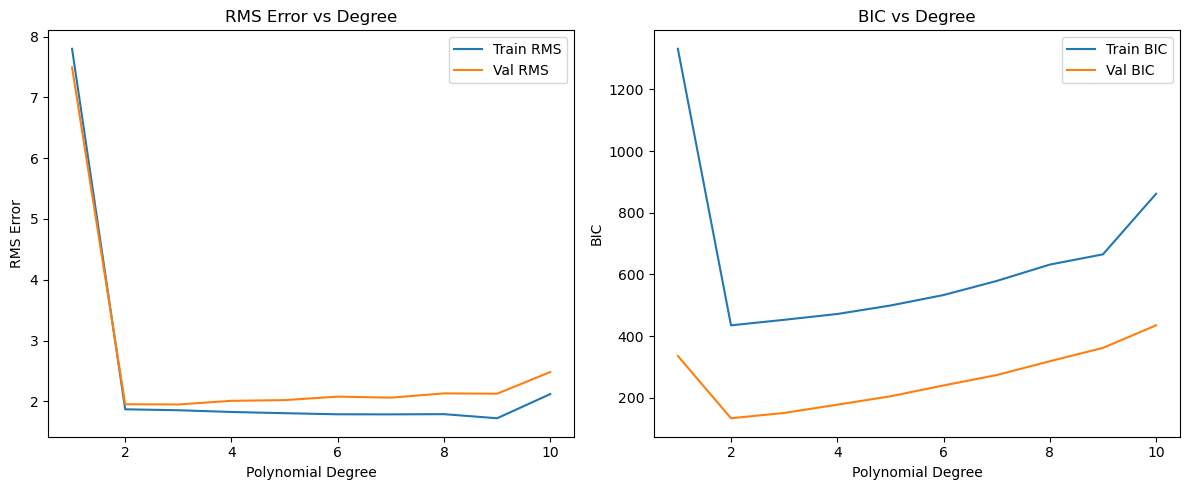

In [264]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
X_temp, X_test, y_temp, y_test, yerr_temp, yerr_test = train_test_split(
    X, y, yerr, test_size=0.2, random_state=42
)

#Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$.

X_train, X_val, y_train, y_val, yerr_train, yerr_val = train_test_split(
    X_temp, y_temp, yerr_temp, test_size=0.2, random_state=42
)

#Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from 
#$1$ to $10$ inclusive.
degrees = range(1, 11)
rms_train = []
rms_val = []
bic_train = []
bic_val = []

n_train = len(X_train)
n_val = len(X_val)

for deg in degrees:
    poly = PolynomialFeatures(degree=deg)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_pred_train = model.predict(X_train_poly)
    y_pred_val = model.predict(X_val_poly)


    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)

    rms_train.append(np.sqrt(mse_train))
    rms_val.append(np.sqrt(mse_val))

    # BIC (number of parameters = number of polynomial terms)
    k = X_train_poly.shape[1] 
    bic_train.append(n_train * np.log(mse_train) + k * np.log(n_train))
    bic_val.append(n_val * np.log(mse_val) + k * np.log(n_val))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, rms_train, label='Train RMS')
plt.plot(degrees, rms_val, label='Val RMS')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMS Error')
plt.legend()
plt.title('RMS Error vs Degree')

plt.subplot(1, 2, 2)
plt.plot(degrees, bic_train, label='Train BIC')
plt.plot(degrees, bic_val, label='Val BIC')
plt.xlabel('Polynomial Degree')
plt.ylabel('BIC')
plt.legend()
plt.title('BIC vs Degree')

plt.tight_layout()
plt.show()

Polynomial regression coefficients: [ 0.          0.05862979  0.36669901  0.49672618 -0.00274562 -0.83662967]


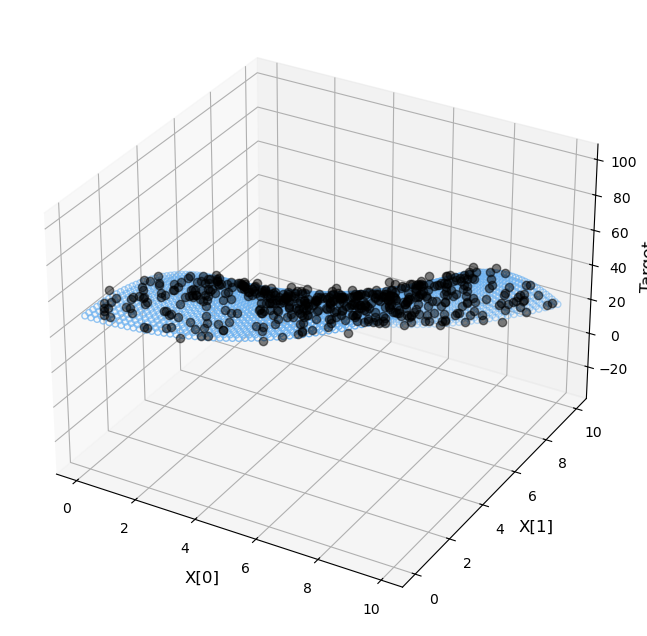

In [268]:
poly = PolynomialFeatures(degree=2)#Fit a $2$th degree polynomial to the data.
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
print("Polynomial regression coefficients:", poly_model.coef_)# Print the best-fit regression

# Predict on the meshgrid (Xgrid) using the polynomial model
Xgrid_poly = poly.transform(Xgrid)  # Transform the meshgrid to match the feature space
y_poly_pred = poly_model.predict(Xgrid_poly)

# Plot the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points
ax.plot(X[:, 0], X[:, 1], y, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)

# Plot the predictions from the polynomial model
ax.scatter(Xgrid[:, 0], Xgrid[:, 1], y_poly_pred, facecolor=(0, 0, 0, 0), s=20, edgecolor='#70b3f0')

# Set the labels for the plot
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

plt.show()